# Using Foolbox attack classes within SecML

In this tutorial we will show how to execute Foolbox's evasion attacks against
machine learning models within SecML.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/15-Foolbox.ipynb)

<div class="alert alert-warning">

**Warning**

Requires installation of the `pytorch` and `foolbox` extra dependencies.
See [extra components](../index.rst#extra-components) for more information.

</div>

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
  import torch
  import foolbox
except ImportError:
  %pip install git+https://gitlab.com/secml/secml#egg=secml[pytorch,foolbox]

## Training the model

The first part of the tutorial replicates the first part of [01-Training](01-Training.ipynb).
We train a SVM RBF Multiclass classifier that will be used for crafting the attacks.
We define here a simple 2D dataset which consists of 3 clusters of points,
so that we can easily visualize the results.

In [2]:
random_state = 999

n_features = 2  # Number of features
n_samples = 1100  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # Centers of the clusters
cluster_std = 0.8  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # Number of training set samples
n_ts = 100  # Number of test set samples

# Split in training and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.kernels import CKernelRBF
clf = CClassifierMulticlassOVA(CClassifierSVM, kernel=CKernelRBF())

# Set classifier's parameters
clf_params = {'C': 0.02, 'kernel.gamma': 50}
clf.set_params(clf_params)

# We can now fit the classifier
clf.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))



2021-07-03 08:32:45,969 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2021-07-03 08:32:45,969 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2021-07-03 08:32:45,978 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2021-07-03 08:32:45,978 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2021-07-03 08:32:45,991 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2021-07-03 08:32:45,991 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2021-07-03 08:32:45,998 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2021-07-03 08:32:45,998 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2021-07-03 08:32:46,004 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments
2021-07-03 08:32:46,004 - secml.settings - INF

## Crafting the Adversarial Examples

Now that the model is trained, we can prepare the attacks against it.
We are going to create adversarial examples using attacks from the Foolbox
library:

  > [[Foolbox]](http://arxiv.org/abs/1707.04131)
  > Rauber, Jonas and Brendel, Wieland and Bethge, Matthias
  > Foolbox: A Python toolbox to benchmark the robustness of machine learning models.
  > Reliable Machine Learning in the Wild Workshop, 34th International Conference on Machine Learning
  > arXiv:1706.06083 [cs, stat]. 2017

To use the attacks from Foolbox in SecML, one can:

 - use the specific classes defined within our library, which wrap directly
  an attack class of Foolbox. These classes define the objective function
  for each attack
 - for new attacks classes and attacks that don't have an objective function,
  e.g., black-box attacks, we can use the generic class wrapper, which takes
  as input the Foolbox attack class with its initialization parameters.

In this notebook, we show the use of the following attacks:

* with specific wrapper included in our library

  > [[PGD]](https://arxiv.org/abs/1706.06083)
  > Madry A, Makelov A, Schmidt L, Tsipras D, Vladu A. Towards Deep Learning Models Resistant to Adversarial Attacks.
  > arXiv:1706.06083 [cs, stat] [Internet]. 2017

  > [[CW]](https://arxiv.org/abs/1608.04644)
  > Carlini N, Wagner D. Towards Evaluating the Robustness of Neural Networks.
  > arXiv:1608.04644 [cs] [Internet]. 2016

* with the generic wrapper

 > [[Salt-and-Pepper]](https://en.wikipedia.org/wiki/Salt-and-pepper_noise)
 > Wikipedia, Salt-and-pepper noise.

We can specify the starting point for the attacks.
The selected point belongs to the class 1, which is in the lower right-corner
of the 2D plane. Finally, we bound the features in the interval '[0, 1]'.

In [3]:
x0, y0 = ts[1, :].X, ts[1, :].Y  # Initial sample
lb, ub = 0.0, 1.0  # Bounds of the attack space

### Projected Gradient Descent (L2)

The first attack we are using against our classifier is the Projected Gradient Descent
algoritmh with a L2 perturbation, which is wrapped with the SecML class `CFoolboxPGDL2`.

Projected Gradient Descent is a technique that finds an adversarial example that satisfies a
norm constraint.

Here we choose a maximum perturbation of 0.2 from the initial point and we run an error-generic
attack for 100 steps.

In [4]:
steps = 100  # Number of iterations
epsilon = 0.2  # Maximum perturbation
y_target = None  # None if `error-generic`, the label of the target class for `error-specific`

from secml.adv.attacks.evasion import CFoolboxPGDL2
pgd_attack = CFoolboxPGDL2(clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=epsilon,
                           abs_stepsize=0.01,
                           steps=steps,
                           random_start=False)
y_pred, _, adv_ds_pgd, _ = pgd_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-L2): ", y_pred.item())

print("Number of classifier function evaluations: {:}"
      "".format(pgd_attack.f_eval))
print("Number of classifier gradient evaluations: {:}"
      "".format(pgd_attack.grad_eval))

Original x0 label:  1
Adversarial example label (PGD-L2):  2
Number of classifier function evaluations: 101
Number of classifier gradient evaluations: 100


As we see, the point has been wrongly classified by our model, exactly as we wanted.

We report the number of function evaluations and gradient evaluations that represent
respectively how many times the methods for predictions and gradient are executed
during the attack.
The corresponding values depends on the number of steps the attack performs and on how the
attack algorithm is defined.

We can also visualize the path that adversarial example took along the iterations,
together with the objective function of the attack.

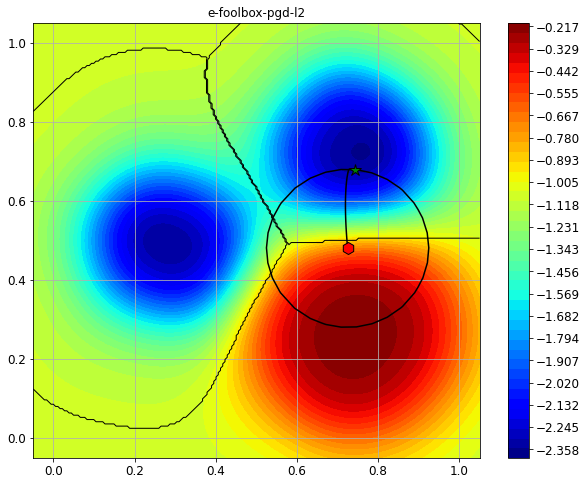

Initial point: CArray([[0.724797 0.479851]])
Adversarial point: CArray([[0.743075 0.679014]])


In [5]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(width=10, height=8, markersize=12)

# Replicate the `l2` constraint used by the attack for visualization
from secml.optim.constraints import CConstraintL2
constraint = CConstraintL2(center=x0, radius=epsilon)
# Plot the attack objective function
fig.sp.plot_fun(pgd_attack.objective_function, plot_levels=False,
                    multipoint=True, n_grid_points=200)
# Plot the decision boundaries of the classifier
fig.sp.plot_decision_regions(clf, plot_background=False, n_grid_points=200)

# Construct an array with the original point and the adversarial example
adv_path_pgd = x0.append(adv_ds_pgd.X, axis=0)

# Function for plotting the optimization sequence
fig.sp.plot_path(pgd_attack.x_seq)

# Function for plotting a constraint
fig.sp.plot_constraint(constraint)

fig.sp.title(pgd_attack.class_type)

fig.show()
fig.sp.grid(grid_on=False)

print("Initial point: {}".format(adv_path_pgd[0, :]))
print("Adversarial point: {}".format(adv_path_pgd[1, :]))

We can see how the initial point (red hexagon) has been perturbed in the feature
space, and that our model classifies the final point as belonging to another class (green star).

### Carlini-Wagner Attack

The next attack we are showing is the Carlini & Wagner L2 attack.
Carlini & Wagner attacks aim to find the smallest possible adversarial perturbation
that causes a misclassification with a given confidence from the classifier.

This time we will run a targeted attack,
sending the point to the leftmost decision region (y = 0).

Original x0 label:  1
Adversarial example label (CW-L2):  0
Number of classifier function evaluations: 901
Number of classifier gradient evaluations: 900


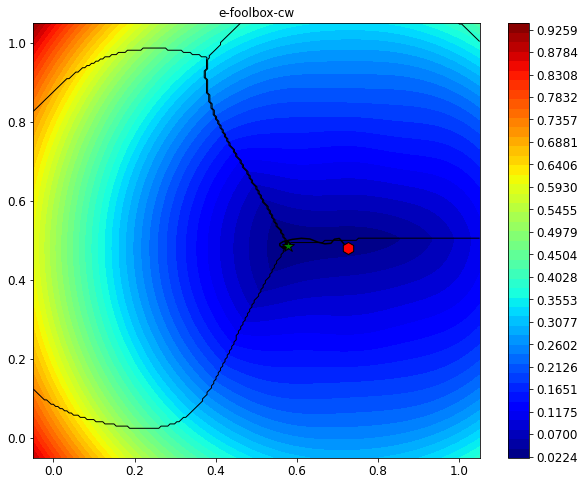

Initial point: CArray([[0.724797 0.479851]])
Adversarial point: CArray([[0.575826 0.4913  ]])


In [6]:
y_target = 0  # target class
stepsize = 0.05
steps = 100

from secml.adv.attacks.evasion import CFoolboxL2CarliniWagner
cw_attack = CFoolboxL2CarliniWagner(clf, y_target,
                                    lb=lb, ub=ub,
                                    steps=steps,
                                    binary_search_steps=9,
                                    stepsize=stepsize,
                                    abort_early=False)
y_pred, _, adv_ds_cw, _ = cw_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (CW-L2): ", y_pred.item())

print("Number of classifier function evaluations: {:}"
      "".format(cw_attack.f_eval))
print("Number of classifier gradient evaluations: {:}"
      "".format(cw_attack.grad_eval))

from secml.figure import CFigure

# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(width=10, height=8, markersize=12)

# Plot the attack objective function
fig.sp.plot_fun(cw_attack.objective_function, plot_levels=False,
                    multipoint=True, n_grid_points=200)
# Plot the decision boundaries of the classifier
fig.sp.plot_decision_regions(clf, plot_background=False, n_grid_points=200)

# Construct an array with the original point and the adversarial example
adv_path_cw = x0.append(adv_ds_cw.X, axis=0)

# Function for plotting the optimization sequence
fig.sp.plot_path(cw_attack.x_seq)

fig.sp.title(cw_attack.class_type)

fig.show()
fig.sp.grid(grid_on=False)

print("Initial point: {}".format(adv_path_cw[0, :]))
print("Adversarial point: {}".format(adv_path_cw[1, :]))

## Using the generic wrapper

If we want to execute a Foolbox attack that is not directly implemented in SecML,
we can use the generic wrapper.
Here we show how to use the generic wrapper to execute on SecML the
[Salt-and-Pepper](https://foolbox.readthedocs.io/en/stable/modules/attacks.html#foolbox.attacks.SaltAndPepperNoiseAttack)
noise attack implemented in Foolbox.

Salt and Pepper noise (usually applied to images), perturbs an increasing number of
feature values bringing them to the limits of the feature space, until the sample is misclassified.

It is indeed a "black-box" attack, i.e., the gradient of the classifier is not
evaluated while performing the attack.

Original x0 label:  1
Adversarial example label (Salt & Pepper):  2
Number of classifier function evaluations: 17
Number of classifier gradient evaluations: 0


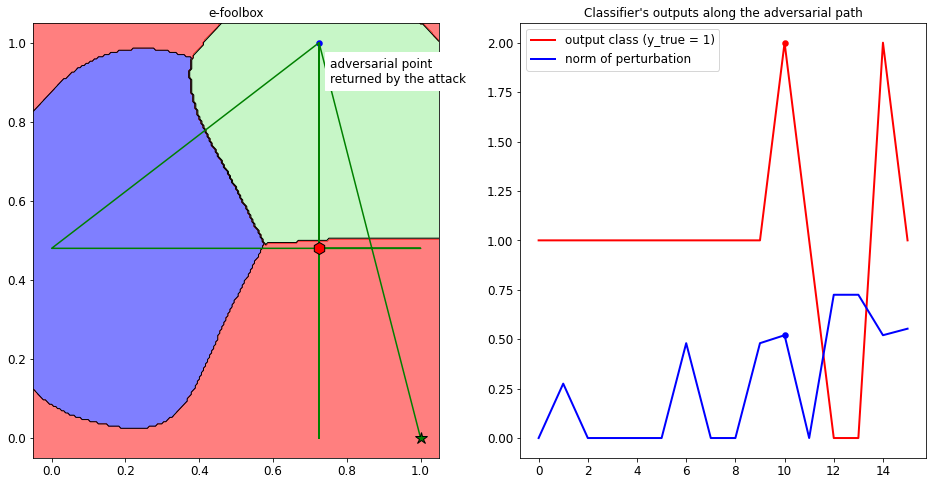

Initial point: CArray([[0.724797 0.479851]])
Adversarial point: CArray([[0.724797 1.      ]])


In [7]:
# set the random state of torch in order to ensure the same
# result, as Salt and Pepper attack exploits randomness
import torch
torch.manual_seed(0)

y_target = None

from secml.adv.attacks.evasion import CAttackEvasionFoolbox
from foolbox.attacks.saltandpepper import SaltAndPepperNoiseAttack

# create the attack
sp_attack = CAttackEvasionFoolbox(clf, y_target,
                                  lb=lb, ub=ub,
                                  fb_attack_class=SaltAndPepperNoiseAttack,
                                  epsilons=None,
                                  steps=15,
                                  across_channels=False)

y_pred, _, adv_ds_sp, _ = sp_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (Salt & Pepper): ", y_pred.item())

print("Number of classifier function evaluations: {:}"
      "".format(sp_attack.f_eval))
print("Number of classifier gradient evaluations: {:}"
      "".format(sp_attack.grad_eval))

from secml.figure import CFigure

# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(width=16, height=8, markersize=12)

# Plot the decision boundaries of the classifier
fig.subplot(1,2,1)
fig.sp.plot_decision_regions(clf, plot_background=True,
                             n_grid_points=200)

# Function for plotting the optimization sequence
fig.sp.plot_path(sp_attack.x_seq, path_color='green')
fig.sp.scatter(adv_ds_sp.X[0, 0], adv_ds_sp.X[0, 1])
fig.sp.text(x=adv_ds_sp.X[0, 0].item() + 0.03,
            y=adv_ds_sp.X[0, 1].item() - 0.1,
            s="adversarial point\nreturned by the attack",
            backgroundcolor='white')

fig.sp.title(sp_attack.class_type)

# classifier's output along the path
true_labels=torch.empty(sp_attack.x_seq.shape[0], dtype=torch.long).fill_(y0.item())
preds, scores = clf.predict(sp_attack.x_seq, return_decision_function=True)
# norm of perturbation along the path
path_distance = (sp_attack.x_seq - x0).norm_2d(order=2, axis=1).ravel()

best_step = (sp_attack.x_seq - adv_ds_sp.X).abs().sum(axis=-1)
best_step = best_step.argmin()

fig.subplot(1,2,2)
fig.sp.title("Classifier's outputs along the adversarial path")
fig.sp.plot(preds, color='r',
            label='output class (y_true = {})'.format(y0.item()))
fig.sp.plot(path_distance, color='b', label='norm of perturbation')
fig.sp.scatter(best_step, preds[best_step], c='r')
fig.sp.scatter(best_step, path_distance[best_step], c='b')
fig.sp.legend()
fig.show()
fig.sp.grid(grid_on=False)

print("Initial point: {}".format(x0))
print("Adversarial point: {}".format(adv_ds_sp.X))

We can see that the number of gradient evaluations is zero, as expected.
The attack is perturbing one feature at a time, by bringing them to the maximum or
minimum value, until the sample is misclassified. From the plot in the right side, we
can see that the best point returned (marked with the dots) is the one that causes a misclassification
with the minimum L2 distance from the clean input x0.

## Crafting Adversarial Example on the MNIST Dataset

We can now use the Foolbox attacks to create adversarial examples against a
convolutional neural network trained on the MNIST dataset.

We first load the MNIST dataset, and the pre-trained model from the model zoo.

In [8]:
n_ts = 1000  # number of testing set samples

# Load MNIST Dataset
from secml.data.loader import CDataLoaderMNIST
digits = (1, 5, 9)
loader = CDataLoaderMNIST()
tr = loader.load('training', digits=digits)
ts = loader.load('testing', digits=digits, num_samples=n_ts)

# Normalize the data
tr.X /= 255
ts.X /= 255


File stored in `/root/secml-data/datasets/mnist/train-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/train-labels-idx1-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-images-idx3-ubyte.gz`

File stored in `/root/secml-data/datasets/mnist/t10k-labels-idx1-ubyte.gz`


In [9]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

# Load pre-trained model
from secml.model_zoo import load_model
clf = load_model('mnist159-cnn')

#Select dataset for the attack
attack_ds = ts[:6, :]

We can use this model to classify the digits and show the accuracy.

In [10]:
labels = clf.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')
acc = metric.performance_score(ts.Y, labels)

print("Model Accuracy: {}".format(acc))

2021-07-03 08:34:29,120 - py.warnings - WARNING - /root/secml-data/models/mnist/mnist3c_cnn.py:26: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  x = torch.relu(torch.max_pool2d(self.conv1(x), 2))

Model Accuracy: 0.997


Now we can craft adversarial example using the attacks previously introduced and
display them as images, to see the results obtained by different attacks.

In [11]:
y_target = None
steps = 100
epsilon = 2.6
pgd_attack = CFoolboxPGDL2(clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=epsilon,
                           abs_stepsize=0.1,
                           steps=steps,
                           random_start=False)

print("PGD-L2 Attack started...")
y_pred_pgd, _, adv_ds_pgd, _ = pgd_attack.run(attack_ds.X, attack_ds.Y)
print("PGD-L2 Attack complete!")

PGD-L2 Attack started...
PGD-L2 Attack complete!


In [12]:
y_target = None
steps = 100
stepsize= 0.03
cw_attack = CFoolboxL2CarliniWagner(clf, y_target,
                                    lb=lb, ub=ub,
                                    steps=steps,
                                    binary_search_steps=9,
                                    stepsize=stepsize,
                                    abort_early=False)

print("CW-L2 Attack started...")
y_pred_cw, _, adv_ds_cw, _ = cw_attack.run(attack_ds.X, attack_ds.Y)
print("CW-L2 Attack complete!")

CW-L2 Attack started...
CW-L2 Attack complete!


In [13]:
y_target = None
sp_attack = CAttackEvasionFoolbox(clf, y_target,
                                  lb=lb, ub=ub,
                                  fb_attack_class=SaltAndPepperNoiseAttack,
                                  epsilons = None)

print("Salt and Pepper Attack started...")
y_pred_sp, _, adv_ds_sp, _ = sp_attack.run(attack_ds.X, attack_ds.Y)
print("Salt and Pepper Attack complete!")

Salt and Pepper Attack started...
Salt and Pepper Attack complete!


Finally, we display both the original and the adversarial digits along with their labels.

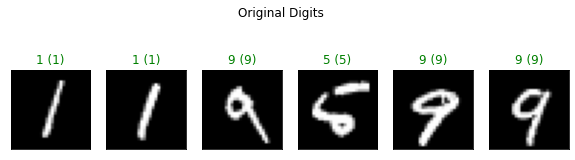

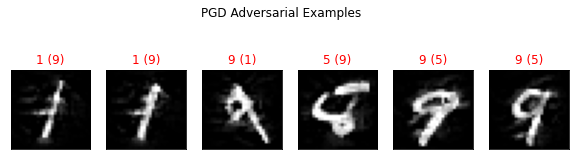

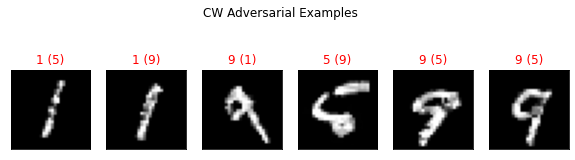

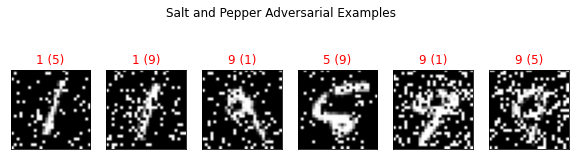

In [14]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

# Function to plot the MNIST dataset
def show_digits(samples, preds, labels, digs, title):
    samples = samples.atleast_2d()
    n_display = samples.shape[0]
    fig = CFigure(width=10, height=3)
    fig.title("{}".format(title))
    for idx in range(n_display):
        fig.subplot(1, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()

show_digits(attack_ds.X[:, :], clf.predict(attack_ds.X[:, :]), attack_ds.Y[:, :], digits, "Original Digits")
show_digits(adv_ds_pgd.X[:, :], clf.predict(adv_ds_pgd.X[:, :]), adv_ds_pgd.Y[:, :], digits, "PGD Adversarial Examples")
show_digits(adv_ds_cw.X[:, :], clf.predict(adv_ds_cw.X[:, :]), adv_ds_cw.Y[:, :], digits, "CW Adversarial Examples")
show_digits(adv_ds_sp.X[:, :], clf.predict(adv_ds_sp.X[:, :]), adv_ds_sp.Y[:, :], digits, "Salt and Pepper Adversarial Examples")
